# **LDA Topic modeling using both published and public resources dataset for training and testing**

In [1]:
import csv
import re
import pandas as pd
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from collections import defaultdict

# We need this dataset in order to use the tokenizer
#nltk.download('punkt')
#import nltk
#nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk import flatten
# Also download the list of stopwords to filter out
#nltk.download('stopwords')
from nltk.corpus import stopwords, wordnet as wn
#nltk.download('wordnet')def get_wordnet_pos(treebank_tag):

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

from nltk import pos_tag

import numpy
numpy.random.seed(1) # setting random seed to get the same training model results each time.

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# these resources are all test resources,which may need to be filtered out from input data
bad_data_id = {
    "c40d9567678740dab868f35440a69b30",
    "c28359056de64680bbdfc64514e1f599",
    "9d5ac26acb8c404fb9ab6e3573ec2c49",
    "316018ccfbdf47928687f81e1b0deb68",
    "fa27117fdf8a462ca320e618dea9a576",
    "9981d0052ae44546912be39ac786a0f9"
}

import pyLDAvis

stop_words = stopwords.words('english')
custom_stop_words = ['include', 'included', 'includes', 'including', 'contain', 'contains', 'containing', 'file', 'et', 'al', 'different', 
                    'dat', 'edu', 'not', 'would', 'say', 'could', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 
                     'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'from', 'published', 
                     'christina', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'used', 'using', 'use', 'public', 
                     'private', 'new', 'west', 'east', 'south', 'north', 'approximately', 'four', 'low', 'high', 'available', 'mile', 'daily', 
                     'year', 'month', 'variable', 'square', 'city', 'foot', 'area', 'within', 'provide', 'firm', 'file', 'state', 'information', 
                     'well', 'university']
stop_words.extend(custom_stop_words)



def process_text(text):
    # Make all the strings lowercase
    text = text.lower()
    # remove urls
    text = re.sub('http[s]?://\S+', '', text)
    # remove non alphabetic characters except dash symbol which is converted to underbar that indicates phrases
    text = re.sub('[-]', '_', text)
    text = re.sub('[^A-Za-z_]', ' ', text.lower())

    # Tokenize the text; this is, separate every sentence into a list of words
    # Since the text is already split into sentences you don't have to call sent_tokenize
    tokenized_text = word_tokenize(text)
    
    tag_map = defaultdict(lambda : wn.NOUN)    
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV    
    
    # Remove the stopwords and lemmatize each word
    clean_text = [
        lemmatizer.lemmatize(word[1:] if word.startswith('_') else word, tag_map[tag[0]]) for word, tag in pos_tag(tokenized_text)
        if word not in stop_words and len(word)>2
    ]
    # this final output is a list of words - remove stop words from lemmatized text to completely remove stop words
    return [word for word in clean_text if word not in stop_words] 

def process_keyword(keyword):
    # remove paratheses
    text = re.sub('\([^()]*\)', '', keyword)
    text = text.strip()    
    # convert dash and space symbols to underbar that indicates phrases
    text = re.sub('[- ]', '_', text)
    return text


In [2]:
# read all published and public hydroshare data
file_name = '/projects/hackathon/ML-Training/hs-ml/data/hs_data.csv'
all_data = [row for row in csv.reader(open(file_name))]
# Remove the first row, since it only has the labels
all_data = all_data[1:]
print('total number of data instances:', len(all_data))

# process keywords
keywords = [row[3].lower().strip().strip(';').split(';') for row in all_data]
for i, kw_list in enumerate(keywords):
    for j, kw in enumerate(kw_list):
        kw_list[j] = process_keyword(kw)
print("total number of keywords: ", len(keywords))


total number of data instances: 4465
total number of keywords:  4465


In [3]:
# concatenate title and abstract to prepare for training texts
all_texts = ['{} {}'.format(row[2], row[4]) for row in all_data]
for i, text in enumerate(all_texts):
    kw_text = ' '.join(keywords[i])
    all_texts[i] = '{} {}'.format(text, kw_text) 

print("Number of full text rows:", len(all_texts))
keywords_set = set(flatten(keywords))
print("number of keywords in keywords_set", len(keywords_set))
#print(keywords_set)


Number of full text rows: 4465
number of keywords in keywords_set 4957


In [4]:
# split total_data into train and test data
from sklearn.model_selection import train_test_split

input_data, test_data, input_keywords, test_keywords = train_test_split(all_texts, keywords, test_size=0.2, train_size=0.8)
print("length of training data: ", len(input_data), ", length of test data: ", len(test_data))

length of training data:  3572 , length of test data:  893


In [5]:
%time docs = [process_text(text) for text in input_data]
#Create Biagram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to texts
# higher threshold means few phrases, heavily depends on scoring function, which can be set as 'default' or 'npmi'
bigram = Phrases(docs, min_count=5, threshold=10, scoring='default') 
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token and token not in docs[idx]:
            # Token is a bigram, add to document.
            docs[idx].append(token)
            #print("in bigram processing: ", token)
    for token in trigram[docs[idx]]:
        if '_' in token and token not in docs[idx]:
            # Token is a bigram, add to document.
            docs[idx].append(token)
            #print("in trigram processing: ", token)


CPU times: user 25.3 s, sys: 105 ms, total: 25.4 s
Wall time: 25.4 s


In [6]:
docs_dictionary = Dictionary(docs)
#docs_dictionary.filter_extremes(no_below=10, no_above=0.2)
corpus = [docs_dictionary.doc2bow(text) for text in docs]
print('number of documents in corpus', len(corpus))
print(docs_dictionary)
#print(docs_dictionary.token2id)

number of documents in corpus 3572
Dictionary(19808 unique tokens: ['collection', 'corps_water_management_system', 'cwm', 'okeechobee', 'resource']...)


In [7]:

# train an LDA model to instruct Gensim to find specified number of topics
# symmetric alpha is default, can also set it to "auto" and 'asymmetric'
# per_word_topics, if set to true, the model also computes a list of topics, sorted in descending order of most likely topics for each word 
# along with their phi values multiplied by the feature length (i.e., word count)
num_of_topics = 14
%time model = LdaModel(corpus, num_topics=num_of_topics, alpha='auto', id2word=docs_dictionary, passes=15, per_word_topics=True)


#topics = model.show_topics(num_words=10, formatted=False)
#print("topics shape: ", model.get_topics().shape)
#for topic in topics:
#    print(topic)
#top_topics = model.top_topics(corpus=corpus, texts=docs, dictionary=docs_dictionary, topn=10, coherence='c_v')
#print("top topics using c_v coherence measure: ")
#for topic in top_topics:
#    print(topic, '\n')


CPU times: user 57.2 s, sys: 731 ms, total: 57.9 s
Wall time: 34.7 s


In [8]:
from pprint import pprint
pprint(model.print_topics())

[(0,
  '0.026*"data" + 0.014*"snow" + 0.013*"water" + 0.011*"site" + 0.009*"depth" '
  '+ 0.007*"access" + 0.007*"metadata" + 0.006*"dataset" + 0.006*"list" + '
  '0.006*"click"'),
 (1,
  '0.030*"sample" + 0.022*"water" + 0.019*"nitrogen" + 0.018*"chemistry" + '
  '0.018*"stream" + 0.016*"dissolve" + 0.010*"carbon" + 0.009*"site" + '
  '0.009*"nitrate" + 0.008*"phosphorus"'),
 (2,
  '0.058*"river" + 0.037*"watershed" + 0.029*"usace" + 0.026*"cwm" + '
  '0.017*"basin" + 0.014*"usace_cwm" + 0.014*"collection" + 0.013*"resource" + '
  '0.010*"flood" + 0.009*"system"'),
 (3,
  '0.073*"model" + 0.015*"data" + 0.011*"test" + 0.011*"input" + '
  '0.010*"simulation" + 0.009*"climate" + 0.007*"output" + 0.006*"landlab" + '
  '0.006*"resource" + 0.006*"water"'),
 (4,
  '0.035*"water" + 0.008*"data" + 0.007*"system" + 0.007*"change" + '
  '0.006*"groundwater" + 0.006*"project" + 0.005*"resource" + 0.005*"utah" + '
  '0.005*"lake" + 0.005*"study"'),
 (5,
  '0.033*"temperature" + 0.027*"data" + 0.0

In [9]:
pprint(model.top_topics(texts=docs, coherence='c_v', topn=10))

[([(0.049225945, 'pequea'),
   (0.043833267, 'creek'),
   (0.03656038, 'mmw'),
   (0.036534023, 'model_my_watershed'),
   (0.036276318, 'mmw_model_my_watershed'),
   (0.03491503, 'watershed'),
   (0.028717268, 'cbf'),
   (0.028442636, 'export'),
   (0.025925472, 'value'),
   (0.025624715, 'sub_watershed')],
  0.9185810843267423),
 ([(0.029797392, 'sample'),
   (0.02237407, 'water'),
   (0.01927542, 'nitrogen'),
   (0.017613828, 'chemistry'),
   (0.017606441, 'stream'),
   (0.01620921, 'dissolve'),
   (0.009826828, 'carbon'),
   (0.009194826, 'site'),
   (0.0086283665, 'nitrate'),
   (0.008391718, 'phosphorus')],
  0.7313550545856666),
 ([(0.10536798, 'historic'),
   (0.080103606, 'precipitation'),
   (0.068730906, 'republic'),
   (0.06861688, 'dominican'),
   (0.03888467, 'discharge'),
   (0.033987503, 'indrhi'),
   (0.03398745, 'dominican_republic'),
   (0.02881383, 'support'),
   (0.021927496, 'historic_precipitation'),
   (0.021617841, 'indrhi_precipitation')],
  0.6690582750209165)

## **Find dominant topic and its percentage contribution in each document instance**

In [10]:
pd.options.display.max_colwidth = 100

sent_topics_df = pd.DataFrame()

for i, row_list in enumerate(model[corpus]):
    row = row_list[0] if model.per_word_topics else row_list
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:
            wp = model.show_topic(topic_num)
            topic_keywords_list = [word for word, prop in wp]
            topic_keywords = "; ".join(topic_keywords_list)
            # compute cosine similarity between topic keywords and input keywords
            topic_keywords_set = {w for w in topic_keywords_list}
            input_keywords_set = {w for w in input_keywords[i]}
            #rvector = topic_keywords_set.union(input_keywords_set)
            rvector = input_keywords_set
            l1 = []; l2 = []
            for w in rvector:
                if w in topic_keywords_set:
                    l1.append(1)
                else:
                    l1.append(0)
                if w in input_keywords_set:
                    l2.append(1)
                else:
                    l2.append(0)
            dot_product = sum(n1*n2 for n1, n2 in zip(l1, l2))
            mag1 = sum(l1)**0.5
            mag2 = sum(l2)**0.5
            if mag1 == 0 or mag2 == 0:
                cos_sim = 0
            else:    
                cos_sim = dot_product/(mag1*mag2)
            sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords, input_keywords[i], cos_sim]), ignore_index=True)            
        else:
            break
            
contents = pd.Series(docs)
sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
sent_topics_df.reset_index()
sent_topics_df.columns = ['Dominant_Topic', 'Percent_Contribution', 'Topic_Keywords', 'Curated', 'Similarity', 'Text']
sent_topics_df
            

,Dominant_Topic,Percent_Contribution,Topic_Keywords,Curated,Similarity,Text
0,2.0,0.9634,river; watershed; usace; cwm; basin; usace_cwm; collection; resource; flood; system,[corps_water_management_system],0.000000,"[usace, cwm, okeechobee, watershed, usace, cwm, okeechobee, watershed, collection, resource, cor..."
1,6.0,0.9677,pequea; creek; mmw; model_my_watershed; mmw_model_my_watershed; watershed; cbf; export; value; s...,"[cbf, mmw, model_my_watershed, pequea]",1.000000,"[land, value, export, sub_watershed, pequea, creek, watershed, cbf, mmw, model_my_watershed, peq..."
2,3.0,0.4037,model; data; test; input; simulation; climate; output; landlab; resource; water,"[central_belt_melange, oak_savanna, sagehorn, northern_california, eel_river_critical_zone_obser...",0.000000,"[exploratory, tree, survey, eel, river, critical, zone, observatory, sagehorn, central, belt, me..."
3,11.0,0.4344,data; hydroshare; model; development; resource; research; forest; open; cuahsi; notebook,"[demo, app, flyer, hydroshare_gis]",0.000000,"[demo, view, multimedia, map, step_by_step, demonstration, add, image, pdfs, video, digital, map..."
4,6.0,0.5399,pequea; creek; mmw; model_my_watershed; mmw_model_my_watershed; watershed; cbf; export; value; s...,"[mmw, model_my_watershed]",1.000000,"[knowlton, knowlton, mmw, model_my_watershed, mmw_model_my_watershed]"
...,...,...,...,...,...,...
3567,10.0,0.7119,data; map; national; dataset; usgs; lidar; point; gi; access; dem,"[hydrologic_unit_code, huc, us, 8_digit, united_states, wbd, sub_basin, watershed, hydrologic_un...",0.000000,"[huc, conus, shapefile, resource, shapefile, huc_, eight, digit, hydrologic, unit, code, contine..."
3568,3.0,0.8959,model; data; test; input; simulation; climate; output; landlab; resource; water,[hs_modflow],0.000000,"[gms, tutorial, test, case, hs_modflow, app, hs_modflow, test_case]"
3569,11.0,0.6600,data; hydroshare; model; development; resource; research; forest; open; cuahsi; notebook,"[climate, landslide, dhsvm, jupyterhub, saturation, cuahsi2017, landlab]",0.000000,"[hydrologic, research, problem, solve, hydroshare, thunder, creek, resource, develop, hydroshare..."
3570,13.0,0.9113,soil; moisture; depth; sensor; forest; sample; temperature; calhoun; vegetation; data,"[reduction_potential, catalina_jemez, soil_redox_potential, jemez_2013_burned_zob]",0.000000,"[cjczo, soil, redox, potential, jemez, burn, zob, reduction, redox, potential, measure, continuo..."


In [11]:
sent_topics_df.to_csv('training_topic_info_data_frame_accurate_14.csv')

## **Find the most representative text for each topic in training data**

In [12]:
sim_series = sent_topics_df['Similarity']
zero_cnt = sim_series.astype(bool).sum()
print("mean of similarity measures: ", sim_series.mean())
print("number of zeros:", zero_cnt, "number of non-zeros:", sim_series.count()-zero_cnt)
print("mean of non-zero similarity measures: ", sim_series.replace(0, numpy.NaN).mean())

mean of similarity measures:  0.2328081007353434
number of zeros: 1277 number of non-zeros: 2295
mean of non-zero similarity measures:  0.6512063710467084


In [13]:
sent_topics_sorted_df = pd.DataFrame()
sent_topics_grp_df = sent_topics_df.groupby('Dominant_Topic')
for i, grp in sent_topics_grp_df:
    sent_topics_sorted_df = pd.concat([sent_topics_sorted_df, grp.sort_values(['Percent_Contribution'], ascending=False).head(1)], axis=0)

print("Mean of dominant_topic_percent_contribution: ", sent_topics_sorted_df[['Percent_Contribution']].mean(axis=0))

# Reset Index    
sent_topics_sorted_df.reset_index(drop=True, inplace=True)
sent_topics_sorted_df


Mean of dominant_topic_percent_contribution:  Percent_Contribution    0.994364
dtype: float64


,Dominant_Topic,Percent_Contribution,Topic_Keywords,Curated,Similarity,Text
0,0.0,0.9979,data; snow; water; site; depth; access; metadata; dataset; list; click,"[urban, utc, land_cover, watershed, tree_canopy, imagerybasemapsearthcover]",0.000000,"[landcover, delaware, river, basin, resolution, land, cover, dataset, delaware, river, basin, co..."
1,1.0,0.9983,sample; water; nitrogen; chemistry; stream; dissolve; carbon; site; nitrate; phosphorus,"[boulder, nitrogen,_particulate_organic, surface_water_chemistry, carbon,_dissolved_organic, clo...",0.000000,"[bcczo, surface, water, chemistry, gg_is_array, gordon, gulch, intermittent, spring, water, samp..."
2,2.0,0.9984,river; watershed; usace; cwm; basin; usace_cwm; collection; resource; flood; system,"[ressim, geohms, usace, iwrss, usace_corps_water_management_system, fia, ras, savannah_river_wat...",0.353553,"[usace, cwm, savannah, river, watershed, corp, water, management, system, cwms, interrelated, mo..."
3,3.0,0.9969,model; data; test; input; simulation; climate; output; landlab; resource; water,"[landlab, ecohydrology, tutorial, actual_landscape, cuahsi_2016]",0.447214,"[cellular_automaton_vegetation_on_actual_landscape, tutorial, demonstrate, implementation, cellu..."
4,4.0,0.9981,water; data; system; change; groundwater; project; resource; utah; lake; study,"[agricultural_water_use_data, crop_coefficients, lower_nooksack_subbasin]",0.000000,"[lnwb, water, management, agricultural, water, data, overview, agricultural, water, irrigation, ..."
5,5.0,0.9971,temperature; data; discharge; flow; site; measurement; dts; water; radiation; measure,"[heat_tracer, distributed_temperature_sensing, well, borehole, flow_rates, ctemps, dts]",0.377964,"[evaluate, in_well, heat, tracer, test, measure, borehole, flow, rate, recent, research, demonst..."
6,6.0,0.9883,pequea; creek; mmw; model_my_watershed; mmw_model_my_watershed; watershed; cbf; export; value; s...,"[nfie, hydrofabric, nhd_plus]",0.000000,"[nfie_geo, pacific, northwest, region, dataset, represent, national, geospatial, framework, nfie..."
7,7.0,0.9749,historic; precipitation; republic; dominican; discharge; indrhi; dominican_republic; support; hi...,"[indrhi, precipitation, historic, el_pinar_de_ocoa, 4416]",0.774597,"[historic, precipitation, pinar, ocoa, dominican, republic, historic, precipitation, pinar, ocoa..."
8,8.0,0.9964,model; rhessys; watershed; elevation; input; notebook; data; taudem; hydrologic; river,"[rhessys, coweeta, rivanna, grass_gis, sub18, parallel]",0.408248,"[jupyter, notebook, demonstrate, rhessys, model, coweeta, sub, rivanna, hpc, hydrologic, model, ..."
9,9.0,0.9973,data; site; iutah; gamut; network; flood; butte; red; control; mopex,"[flood_insurance_rate_map, cbrs, coastal_flooding, base_flood_elevation, transportation, environ...",0.000000,"[national, flood, hazard, layer, buck, county, national, flood, hazard, layer, nfhl, data, incor..."


## **Word Clouds of Top 10 Keywords in Each Topic**

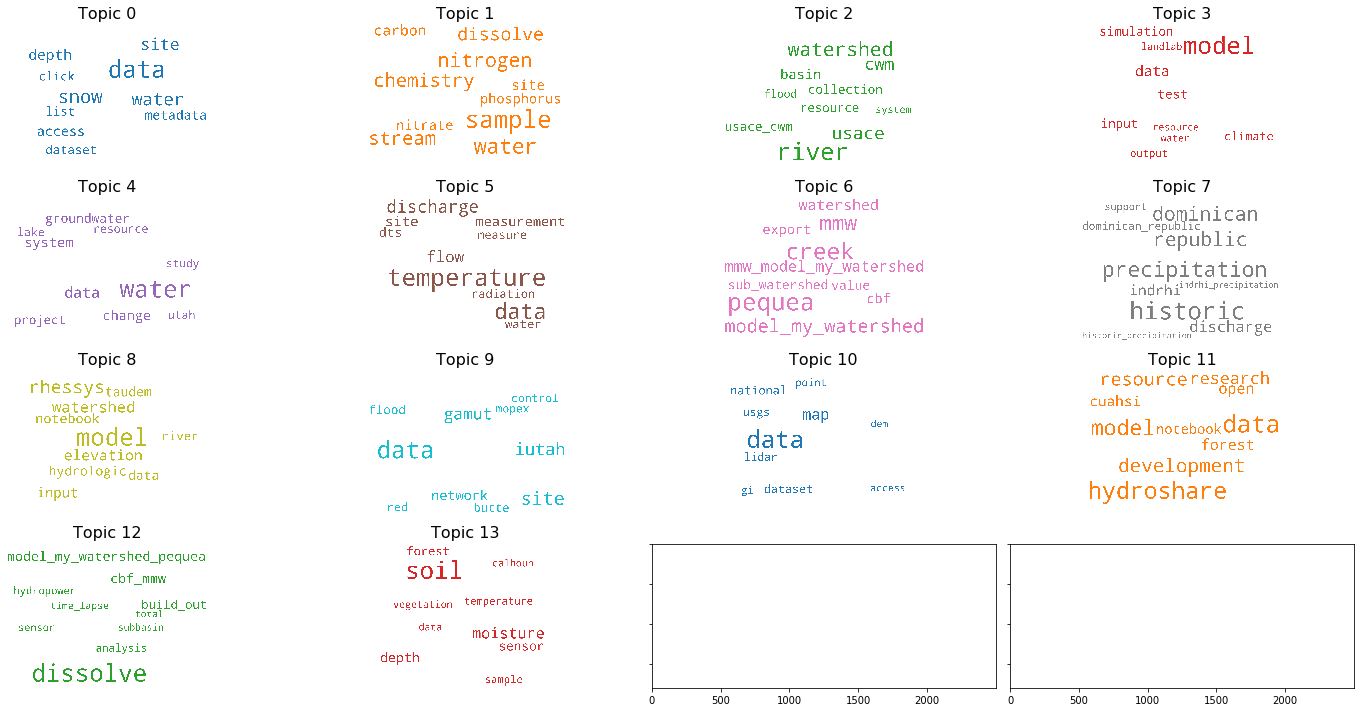

In [14]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors


def topics_per_document(model, corpus, start=0, end=-1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, word_topics, word_phi_values = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)


cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
topics = model.show_topics(num_topics=num_of_topics, formatted=False)

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i-len(cols)] if i >= len(cols) else cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(4, 4, figsize=(20,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i >= len(topics):
        break
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
dominant_topics, topic_percentages = topics_per_document(model=model, corpus=corpus)  

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## **Word Counts of Top Topic Keywords**

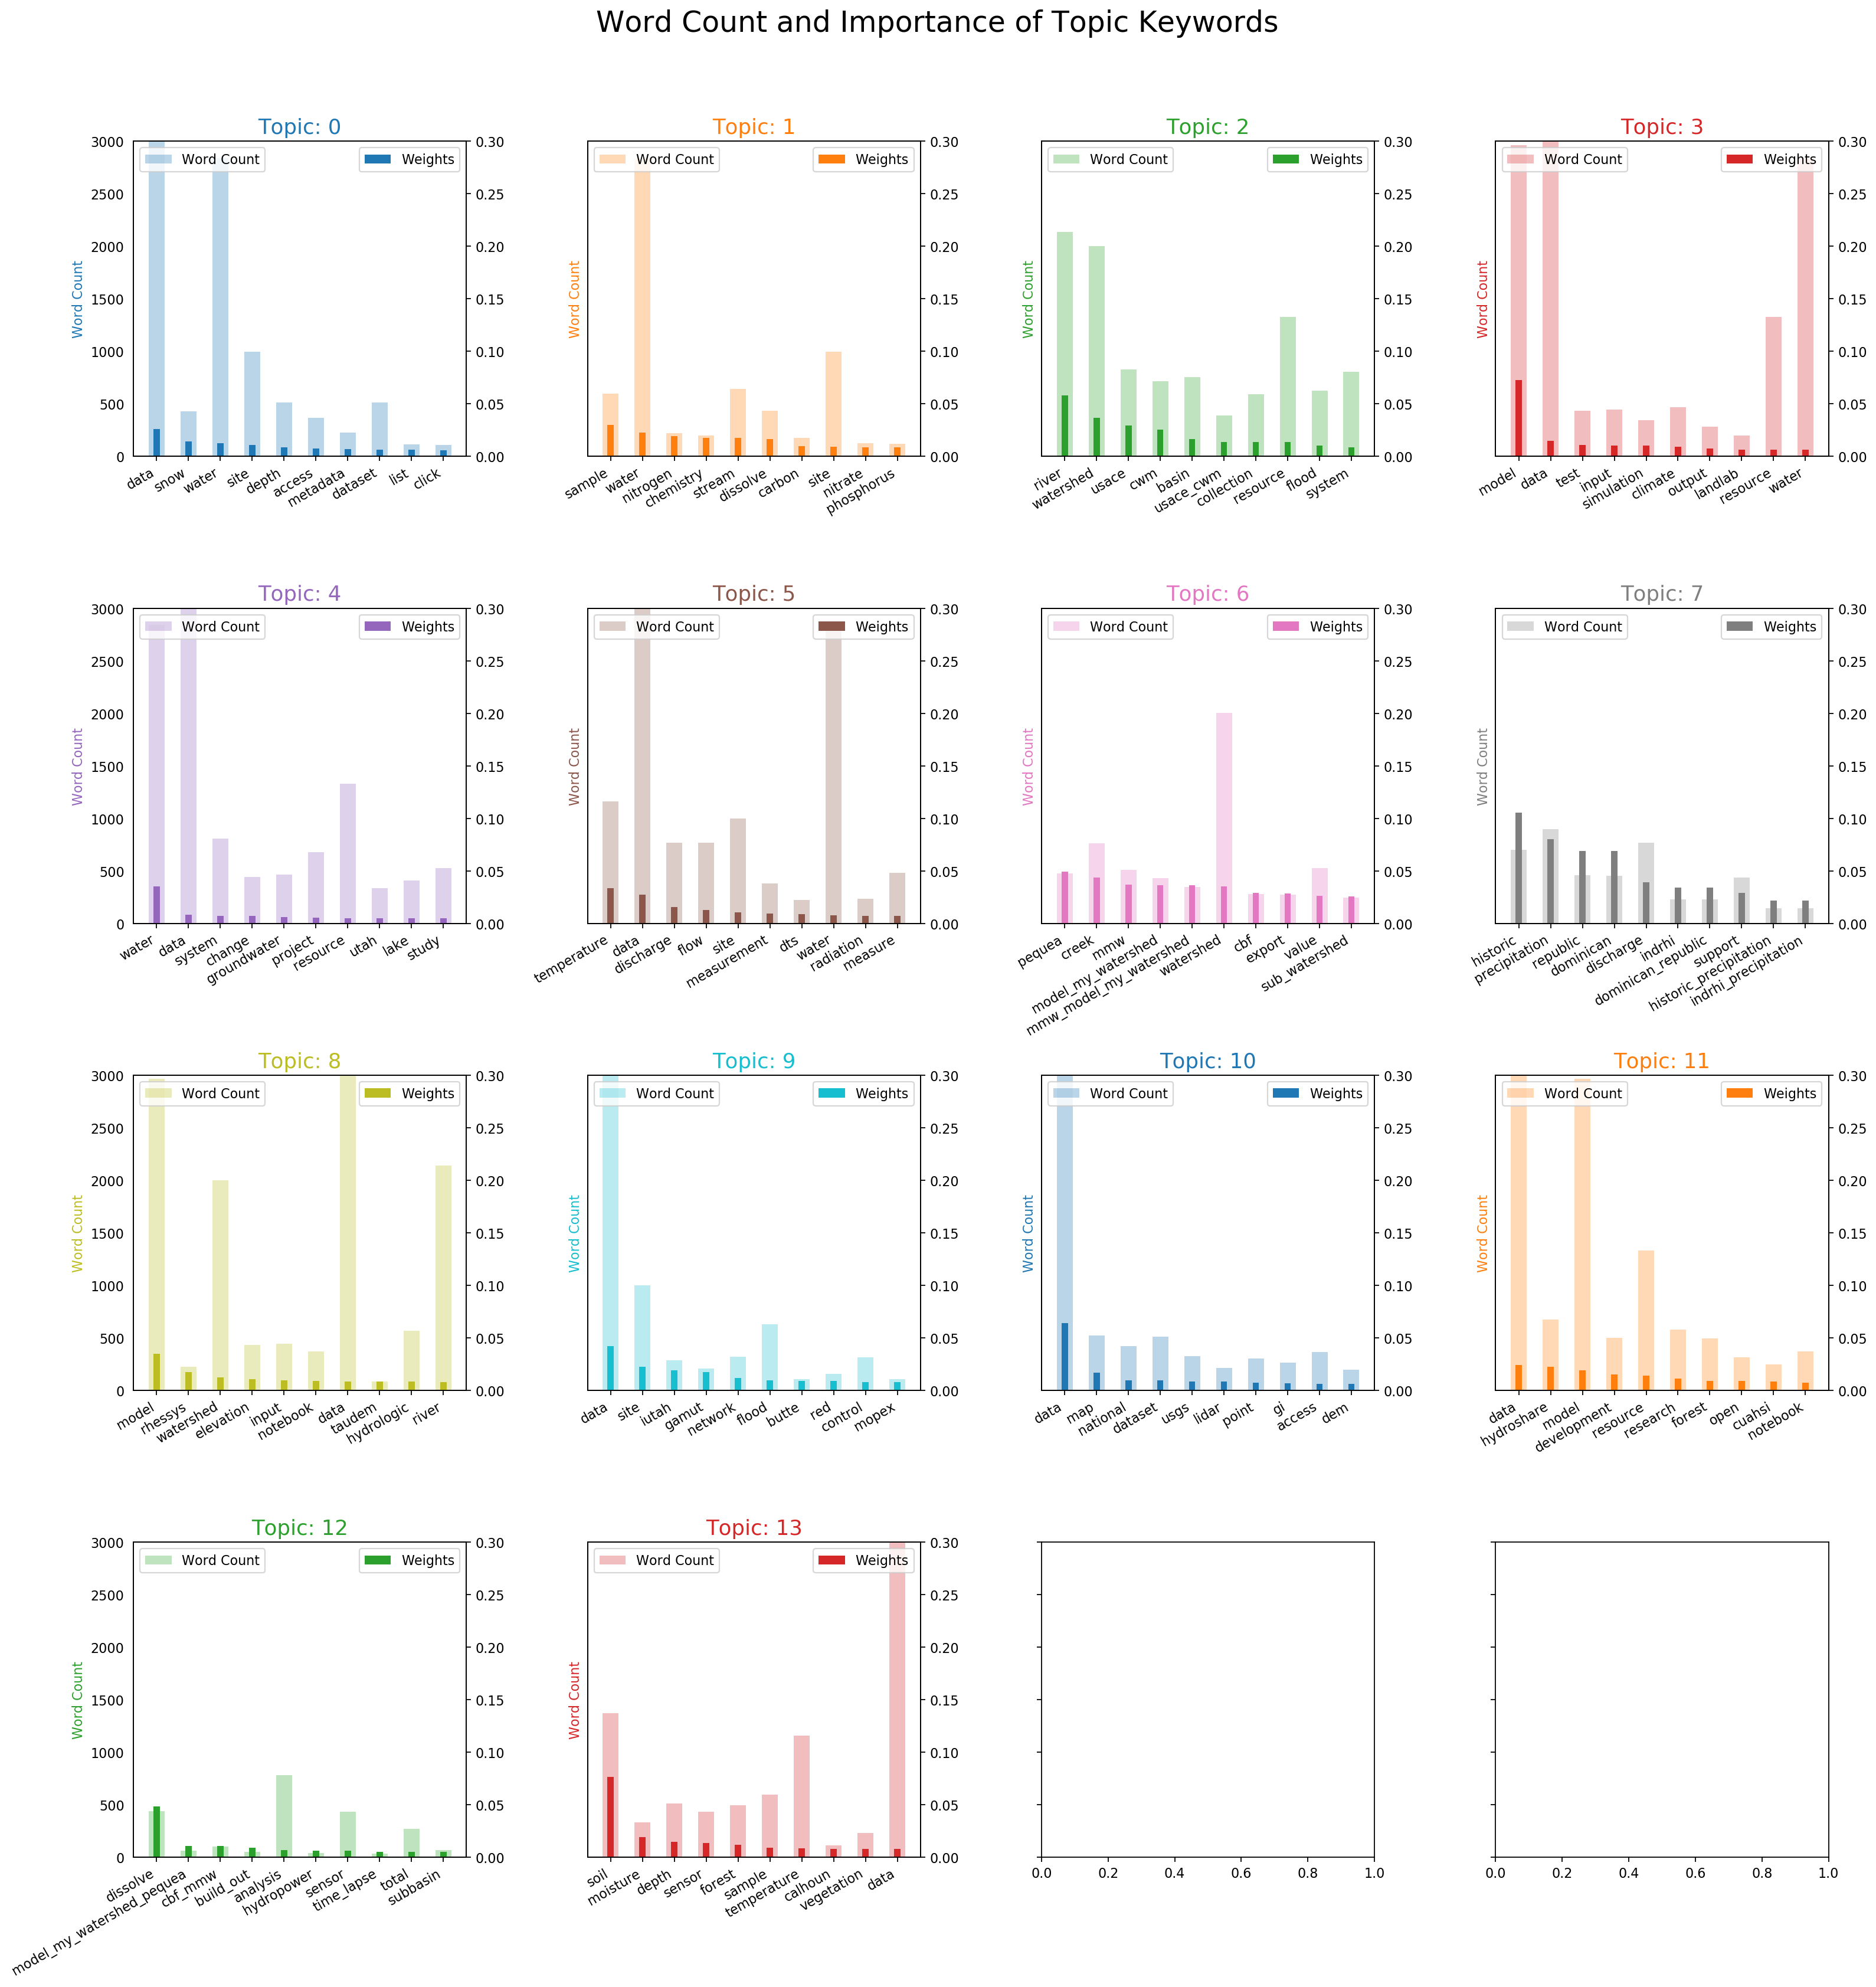

In [15]:
from collections import Counter
topics = model.show_topics(num_topics=num_of_topics, formatted=False)
data_flat = [w for w_list in docs for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 4, figsize=(20,20), sharey=True, dpi=160)
for i, ax in enumerate(axes.flatten()):
    if i >= len(topics):
        break
    clr = cols[i-len(cols)] if i >= len(cols) else cols[i]
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=clr, width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=clr, width=0.2, label='Weights')    
    ax.set_ylabel('Word Count', color=clr)
    ax_twin.set_ylim(0, 0.3); ax.set_ylim(0, 3000)
    ax.set_title('Topic: ' + str(i), color=clr, fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); 
    ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## **What are the most discussed topics in the training data**

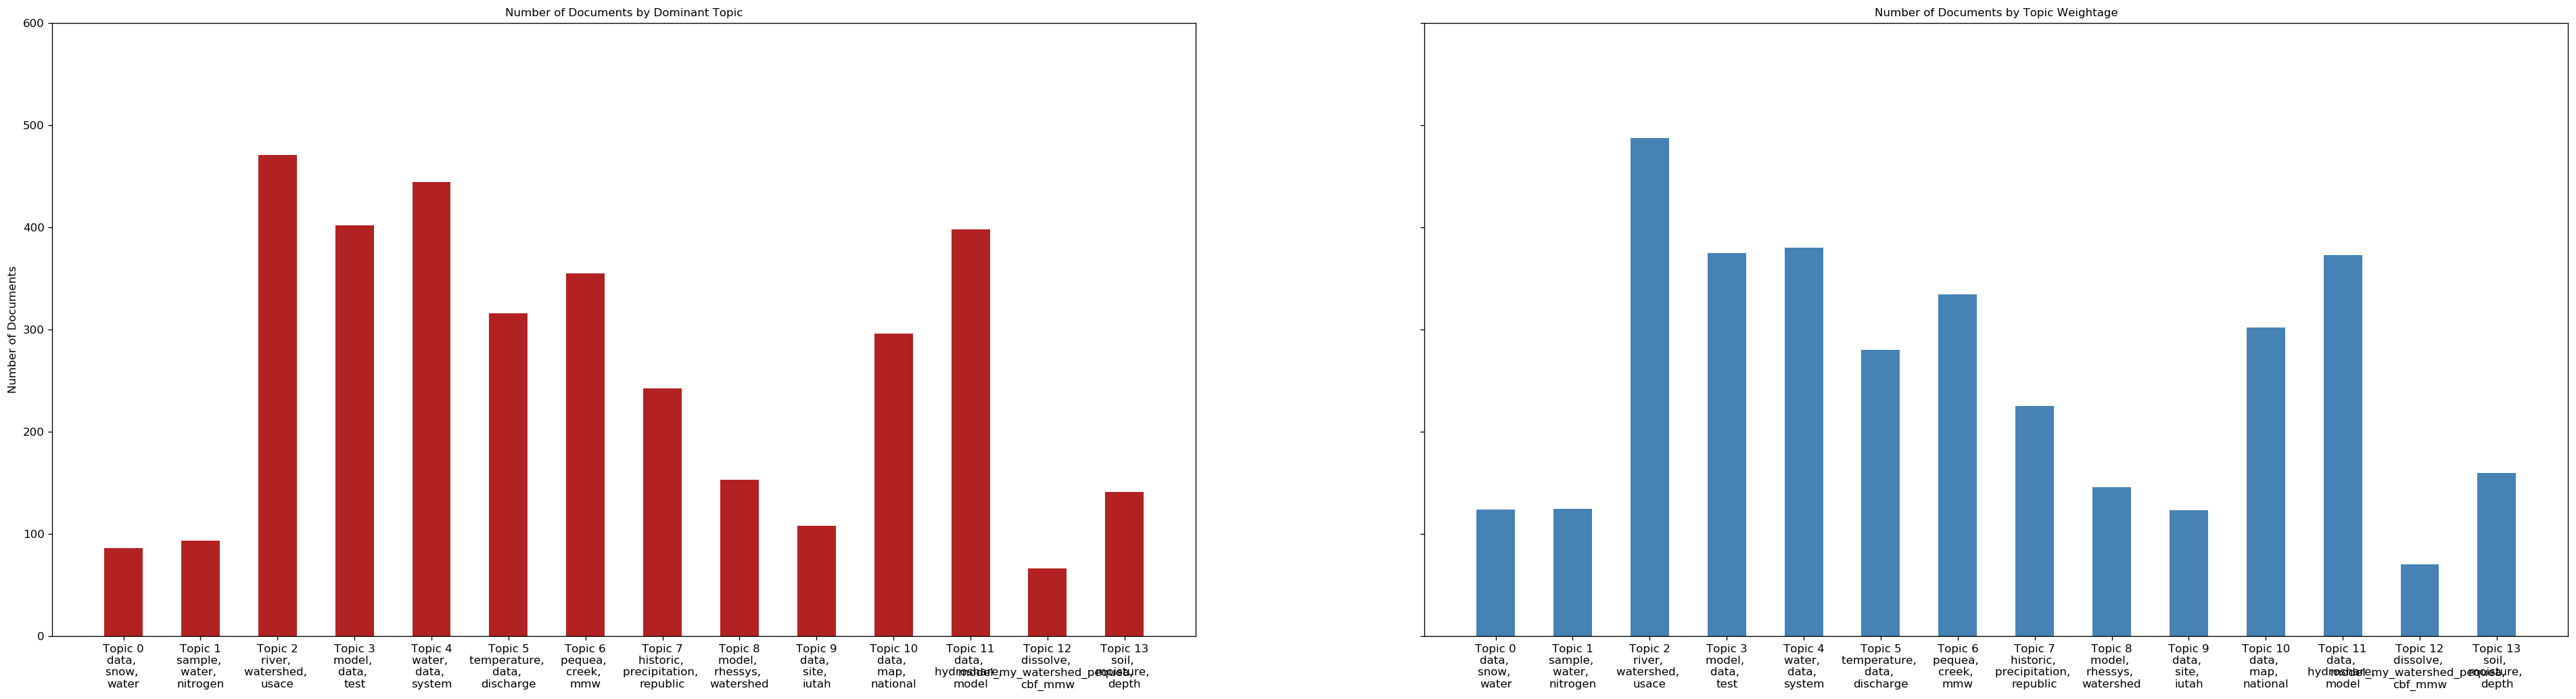

In [16]:
from matplotlib.ticker import FuncFormatter


dominant_topics, topic_percentages = topics_per_document(model=model, corpus=corpus)  

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in model.show_topics(num_topics=num_of_topics, formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 10), dpi=120, sharey=True)
# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 600)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [29]:
import pickle
with open("training_corpus.txt", 'wb') as fp:
    pickle.dump(corpus, fp)

## **Visualize LDA model using pyLDAVis for training data**

In [17]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary=model.id2word, sort_topics=False)
vis

/opt/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.017289 -0.097463       1        1   4.237586
1     -0.101245 -0.119700       2        1   4.152627
2      0.008759  0.102962       3        1  11.654572
3      0.187798  0.077790       4        1   9.902605
4      0.149418 -0.045977       5        1  17.825672
5      0.051996 -0.171841       6        1  10.397554
6     -0.203943  0.184831       7        1   3.420044
7     -0.243468  0.111619       8        1   2.306361
8      0.076277  0.124472       9        1   3.762010
9     -0.025470 -0.043529      10        1   4.415735
10     0.129493 -0.004118      11        1   9.128673
11     0.166113  0.153279      12        1  11.077400
12    -0.181917 -0.071148      13        1   1.857475
13    -0.031100 -0.201177      14        1   5.861683, topic_info=    Category         Freq           Term        Total  loglift  logprob
330  Default  2893.000000          model  2893.000000  30.0000  30.0000
877  Default  1303.000000           soil  1303.000000  29.0000  29.0000
222  Default  4460.000000           data  4460.000000  28.0000  28.0000
106  Default  2107.000000          river  2107.000000  27.0000  27.0000
509  Default   810.000000  precipitation   810.000000  26.0000  26.0000
..       ...          ...            ...          ...      ...      ...
252  Topic14    74.425896        collect   494.159302   0.9437  -5.2568
439  Topic14   109.106583          water  2802.373047  -0.4092  -4.8743
222  Topic14   110.890678           data  4460.571777  -0.8578  -4.8581
679  Topic14    65.062569    measurement   359.473999   1.1274  -5.3913
143  Topic14    49.657990            map   498.671600   0.5299  -5.6615

[924 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
359       1  0.217702  access
359       5  0.011768  access
359       6  0.008826  access
359      10  0.064722  access
359      11  0.408927  access
...     ...       ...     ...
125       3  0.012295    zone
125       5  0.229504    zone
125       6  0.299175    zone
125      11  0.065573    zone
125      14  0.319666    zone

[2212 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

## **Test the model on test data unseen by the model**

In [18]:
#print("total number of test data keywords: ", len(test_keywords), ", keywords: ", test_keywords)
print("total number of test data keywords: ", len(test_keywords))
test_keywords_set = set(flatten(test_keywords))
#print(test_keywords_set)
print("number of test keywords in test_keywords_set", len(test_keywords_set))
print("Number of full test text rows:", len(test_data))

total number of test data keywords:  893
number of test keywords in test_keywords_set 1696
Number of full test text rows: 893


In [19]:
test_docs = [process_text(text) for text in test_data]

#Create Biagram & Trigram Models 
# Add bigrams and trigrams to texts
# higher threshold means few phrases, heavily depends on scoring function, which can be set as 'default' or 'npmi'
test_bigram = Phrases(test_docs, min_count=5, threshold=10, scoring='default') 
test_trigram = Phrases(test_bigram[test_docs])

for idx in range(len(test_docs)):
    for token in test_bigram[test_docs[idx]]:
        if '_' in token and token not in test_docs[idx]:
            # Token is a bigram, add to document.
            test_docs[idx].append(token)
            #print("in bigram processing: ", token)
    for token in test_trigram[test_docs[idx]]:
        if '_' in token and token not in test_docs[idx]:
            # Token is a bigram, add to document.
            test_docs[idx].append(token)
            #print("in trigram processing: ", token)

test_bows = [model.id2word.doc2bow(text) for text in test_docs]

test_sent_topics_df = pd.DataFrame()

for i, row_list in enumerate(model[test_bows]):
    row = row_list[0] if model.per_word_topics else row_list
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:
            wp = model.show_topic(topic_num)
            topic_keywords_list = [word for word, prop in wp]
            topic_keywords = "; ".join(topic_keywords_list)
            # compute cosine similarity between topic keywords and input keywords
            topic_keywords_set = {w for w in topic_keywords_list}
            test_keywords_set = {w for w in test_keywords[i]}
            #rvector = topic_keywords_set.union(input_keywords_set)
            rvector = test_keywords_set
            l1 = []; l2 = []
            for w in rvector:
                if w in topic_keywords_set:
                    l1.append(1)
                else:
                    l1.append(0)
                if w in test_keywords_set:
                    l2.append(1)
                else:
                    l2.append(0)
            dot_product = sum(n1*n2 for n1, n2 in zip(l1, l2))
            mag1 = sum(l1)**0.5
            mag2 = sum(l2)**0.5
            if mag1 == 0 or mag2 == 0:
                cos_sim = 0
            else:    
                cos_sim = dot_product/(mag1*mag2)
            test_sent_topics_df = test_sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords, test_keywords[i], cos_sim]), ignore_index=True)           
        else:
            break
            
contents = pd.Series(test_docs)
test_sent_topics_df = pd.concat([test_sent_topics_df, contents], axis=1)
test_sent_topics_df.reset_index()
test_sent_topics_df.columns = ['Dominant_Topic', 'Percent_Contribution', 'Topic_Keywords', 'Curated', 'Similarity', 'Text']
test_sent_topics_df

#doc_lda = model[bow]
#print('\ndoc_lda:', doc_lda)

#doc_topics, word_topics, phi_values = model.get_document_topics(bow, per_word_topics=True)
#for topic_id, prob in doc_topics:
#    terms = model.show_topic(topic_id)


,Dominant_Topic,Percent_Contribution,Topic_Keywords,Curated,Similarity,Text
0,2.0,0.7945,river; watershed; usace; cwm; basin; usace_cwm; collection; resource; flood; system,[corps_water_management_system],0.000000,"[usace, cwm, kaskaskia, watershed, usace, cwm, kaskaskia, watershed, collection, corps_water_man..."
1,2.0,0.9777,river; watershed; usace; cwm; basin; usace_cwm; collection; resource; flood; system,[usace_corps_water_management_system],0.000000,"[usace, cwm, red, river, watershed, swf, study, usace, cwm, red, river, watershed, swf, collecti..."
2,7.0,0.9604,historic; precipitation; republic; dominican; discharge; indrhi; dominican_republic; support; hi...,"[indrhi, discharge, historic, la_guama_i, 220001]",0.774597,"[historic, discharge, guama, dominican, republic, historic, discharge, guama, dominican, republi..."
3,11.0,0.9131,data; hydroshare; model; development; resource; research; forest; open; cuahsi; notebook,[uiseminar],0.000000,"[idaho, seminar, consortium, advancement, hydrologic, science, inc, cuahsi, operate, hydroshare,..."
4,2.0,0.9657,river; watershed; usace; cwm; basin; usace_cwm; collection; resource; flood; system,[usace_corps_water_management_system],0.000000,"[usace, cwm, boise, river, watershed, bank, usace, cwm, boise, river, watershed, collection, res..."
...,...,...,...,...,...,...
888,9.0,0.5527,data; site; iutah; gamut; network; flood; butte; red; control; mopex,"[red_butte_gate_aquatic, qc1, gamut, stage_discharge, rating_curve, aquatic_station, red_butte_g...",0.308607,"[wasatch, environmental, observatory, red, butte, network, discharge, rating, curve, red, butte,..."
889,1.0,0.4958,sample; water; nitrogen; chemistry; stream; dissolve; carbon; site; nitrate; phosphorus,"[shale_hills, surface_water_chemistry, carbon,_dissolved_organic, water_depth, temperature, pota...",0.000000,"[sshczo, groundwater, chemistry, surface, water, chemistry, shaver, creek, surface, groundwater,..."
890,6.0,0.9677,pequea; creek; mmw; model_my_watershed; mmw_model_my_watershed; watershed; cbf; export; value; s...,"[cbf, mmw, model_my_watershed, pequea]",1.000000,"[land, value, export, sub_watershed, pequea, creek, watershed, cbf, mmw, model_my_watershed, peq..."
891,11.0,0.4926,data; hydroshare; model; development; resource; research; forest; open; cuahsi; notebook,"[training, optimization, communication, water_resources_systems_analysis, practice, semi_structu...",0.000000,"[data, script, support, analysis, water, resource, system, course, sysllabi, resource, describe,..."


In [20]:
test_sent_topics_df.to_csv('testing_topic_info_data_frame_accurate_14.csv')

In [21]:
test_sim_series = test_sent_topics_df['Similarity']
test_zero_cnt = test_sim_series.astype(bool).sum()
print("mean of similarity measures: ", test_sim_series.mean())
print("number of zeros:", test_zero_cnt, "number of non-zeros:", test_sim_series.count()-test_zero_cnt)
print("mean of non-zero similarity measures: ", test_sim_series.replace(0, numpy.NaN).mean())

mean of similarity measures:  0.22507458631840163
number of zeros: 306 number of non-zeros: 587
mean of non-zero similarity measures:  0.6568353123605642


## **Find the most representative text for each topic in test data**

In [22]:
test_sent_topics_sorted_df = pd.DataFrame()
test_sent_topics_grp_df = test_sent_topics_df.groupby('Dominant_Topic')
for i, grp in test_sent_topics_grp_df:
    test_sent_topics_sorted_df = pd.concat([test_sent_topics_sorted_df, grp.sort_values(['Percent_Contribution'], ascending=False).head(1)], axis=0)
print("Mean of dominant_topic_percent_contribution: ", test_sent_topics_sorted_df[['Percent_Contribution']].mean(axis=0))    
# Reset Index    
test_sent_topics_sorted_df.reset_index(drop=True, inplace=True)
test_sent_topics_sorted_df

Mean of dominant_topic_percent_contribution:  Percent_Contribution    0.96895
dtype: float64


,Dominant_Topic,Percent_Contribution,Topic_Keywords,Curated,Similarity,Text
0,0.0,0.9950,data; snow; water; site; depth; access; metadata; dataset; list; click,"[wetlands, bogs, hydrography, fens, swamps, marshes, deepwater_habitats, surface_water]",0.000000,"[national, wetland, inventory, delaware, data, set, represent, extent, approximate, location, ty..."
1,1.0,0.9868,sample; water; nitrogen; chemistry; stream; dissolve; carbon; site; nitrate; phosphorus,"[kosñipata_valley, peru, landslides]",0.000000,"[region, landslide, mapping, ko, ipata, valley, peru, clark, please, cite, clark, hilton, asner,..."
2,2.0,0.9907,river; watershed; usace; cwm; basin; usace_cwm; collection; resource; flood; system,"[cumberland_watershed, corps_water_management_system, usace, iwrss]",0.500000,"[usace, cwm, cumberland, watershed, corp, water, management, system, cwms, interrelated, model, ..."
3,3.0,0.9877,model; data; test; input; simulation; climate; output; landlab; resource; water,"[ueb, animas, snowmelt]",0.000000,"[ueb, snowmelt, simulation, anima, watershed, create, hydroshare, ueb, model, input, preparation..."
4,4.0,0.9944,water; data; system; change; groundwater; project; resource; utah; lake; study,"[artificial_drainage_shape_files, tile_drained_fields]",0.000000,"[lnwb, artificial, drainage, tile, drain, field, shape, compress, gi, phaseiiitask, create, ditc..."
5,5.0,0.9946,temperature; data; discharge; flow; site; measurement; dts; water; radiation; measure,"[amazon, rainforest, rainforest___savanna_transition_zone, brazil, rainfall, rain, precipitation...",0.000000,"[rain, gauge, data, brazilian, rainforest_savanna, transition, zone, data, rain, gauge, time, se..."
6,6.0,0.9677,pequea; creek; mmw; model_my_watershed; mmw_model_my_watershed; watershed; cbf; export; value; s...,"[cbf, mmw, model_my_watershed, pequea]",1.000000,"[land, value, export, sub_watershed, pequea, creek, watershed, cbf, mmw, model_my_watershed, peq..."
7,7.0,0.9700,historic; precipitation; republic; dominican; discharge; indrhi; dominican_republic; support; hi...,"[indrhi, precipitation, historic, palo_verde, 429]",0.774597,"[historic, precipitation, palo, verde, dominican, republic, historic, precipitation, palo, verde..."
8,8.0,0.9938,model; rhessys; watershed; elevation; input; notebook; data; taudem; hydrologic; river,"[surface_water, parflow, urban_hydrology, groundwater, hydrologic_modeling]",0.000000,"[parflow, clm, model, input, six, headwater, catchment, gwynn, fall, watershed, baltimore, count..."
9,9.0,0.9825,data; site; iutah; gamut; network; flood; butte; red; control; mopex,"[gamut, rb_tm_c, climate_station, knowlton_fork, weo, raw_data, red_butte_canyon, tm_c, universi...",0.392232,"[wasatch, environmental, observatory, red, butte, network, todd, meadow, climate, rb_tm_c, datas..."


## **Visualize LDA model using pyLDAVis for test data**

In [23]:
test_vis = pyLDAvis.gensim.prepare(model, test_bows, dictionary=model.id2word, sort_topics=False)
test_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.017289 -0.097463       1        1   3.702046
1     -0.101245 -0.119700       2        1   4.094361
2      0.008759  0.102962       3        1  10.162750
3      0.187798  0.077790       4        1   7.943425
4      0.149418 -0.045977       5        1  21.534086
5      0.051996 -0.171841       6        1  10.290008
6     -0.203943  0.184831       7        1   3.409818
7     -0.243468  0.111619       8        1   1.475227
8      0.076277  0.124472       9        1   3.945271
9     -0.025470 -0.043529      10        1   5.076577
10     0.129493 -0.004118      11        1   9.173671
11     0.166113  0.153279      12        1  12.439358
12    -0.181917 -0.071148      13        1   1.519095
13    -0.031100 -0.201177      14        1   5.234304, topic_info=    Category        Freq           Term       Total  loglift  logprob
330  Default  570.000000          model  570.000000  30.0000  30.0000
877  Default  255.000000           soil  255.000000  29.0000  29.0000
222  Default  991.000000           data  991.000000  28.0000  28.0000
106  Default  414.000000          river  414.000000  27.0000  27.0000
509  Default  137.000000  precipitation  137.000000  26.0000  26.0000
..       ...         ...            ...         ...      ...      ...
252  Topic14   14.418083        collect  111.111000   0.9079  -5.2568
439  Topic14   21.136566          water  662.074463  -0.4944  -4.8743
222  Topic14   21.482187           data  991.782349  -0.8823  -4.8581
679  Topic14   12.604182    measurement   77.081009   1.1391  -5.3913
143  Topic14    9.619946            map  108.561050   0.5265  -5.6615

[921 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
359       1  0.185885  access
359       5  0.013277  access
359       6  0.013277  access
359      10  0.066387  access
359      11  0.398325  access
...     ...       ...     ...
125       3  0.018821    zone
125       5  0.282316    zone
125       6  0.301137    zone
125      11  0.056463    zone
125      14  0.282316    zone

[1936 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

## **Save the model which can be loaded directly later**

In [24]:
model_file_name = '/projects/hackathon/ML-Training/hs-ml/data/model/hs_lda_model'

# save model to disk
model.save(model_file_name)

## **Save model results for topic classification to validate the model**

In [25]:
topic_output_data = '/projects/hackathon/ML-Training/hs-ml/data/topic_data/topics_14.csv'

%time all_docs = [process_text(text) for text in all_texts]
all_bigram = Phrases(all_docs, min_count=5, threshold=10, scoring='default') 
all_trigram = Phrases(all_bigram[all_docs])

for idx in range(len(all_docs)):
    for token in all_bigram[all_docs[idx]]:
        if '_' in token and token not in all_docs[idx]:
            # Token is a bigram, add to document.
            all_docs[idx].append(token)
            #print("in bigram processing: ", token)
    for token in all_trigram[all_docs[idx]]:
        if '_' in token and token not in all_docs[idx]:
            # Token is a bigram, add to document.
            all_docs[idx].append(token)
            #print("in trigram processing: ", token)

all_corpus = [model.id2word.doc2bow(text) for text in all_docs]
print('number of documents in all_corpus', len(all_corpus))


CPU times: user 29.1 s, sys: 58 ms, total: 29.2 s
Wall time: 29.2 s
number of documents in all_corpus 4465


In [26]:
with open(topic_output_data, 'w', newline='', encoding='utf-8') as f:
    output_writer = csv.writer(f)
    header_list = ['UUID', 'Status', 'Title', 'Keywords', 'Topics']
    output_writer.writerow(header_list)
    cnt = 0
    for i, row_list in enumerate(model[all_corpus]):
        row = row_list[0] if model.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = model.show_topic(topic_num, topn=20)
                topic_keywords = "; ".join([word for word, prop in wp])
                output_writer.writerow([all_data[i][0], all_data[i][1], all_data[i][2], all_data[i][3], topic_keywords])
                cnt += 1
            else:
                break
            
    print('cnt=', cnt)

cnt= 4465
